<meta property='og:image' content='https://www.information-age.com/wp-content/uploads/2018/11/data-era-1013x440.jpeg'>

![](https://www.information-age.com/wp-content/uploads/2018/11/data-era-1013x440.jpeg)

<h1><center> Crime & Economy (in python) </center></h1>

In this project I look for a relationship between economic data and crime rates. 

I obtained statistics for various industries at the county level from the Bureau of Labor Statistics. I also found the number of arrests and charges for a variety of crimes at the county level from the Inter-University Consortium for Political and Social Research. These datasets span from 2009, 2010, 2012, 2014, and 2016.

After cleaning the data I will test out some statistical analysis.

\---------------------------------------------------------------------------

BLS, link to data: https://www.bls.gov/cew/datatoc.htm

ICPSR / Crime, link to data: https://www.icpsr.umich.edu/icpsrweb/NACJD/series/57 (seires name: "Uniform Crime Reporting Program Data: County-Level Detailed Arrest and Offense Data, United States, yyyy")

Authors Linkedin: https://www.linkedin.com/in/matt-krieger-094/

In [192]:
# Project
%run Imports.ipynb
# Imports functions from seperate notebook
%run Functions.ipynb

C:\Users\Matt\Downloads\Data and First Regress


Here I load in the data and spit out some summary statistics on the structure of the data.

In [193]:
# Reading in Data
start_time = timeit.default_timer()
# Keys to extract formatted State and County names
key00 = pd.read_csv('FIPS_countycodes.txt',delimiter=',')  # Counties only
key00['GU Name'] = key00['GU Name'].str[:-7]  # Slice 'county' from names
# Crime
crime2009 = pd.read_csv('30763-0001-crimedata2009.txt',delimiter='\t')
crime2009['year'] = 2009
crime2010 = pd.read_csv('33523-0001-crimedata2010.txt',delimiter='\t')
crime2010['year'] = 2010
crime2012 = pd.read_csv('35019-0001-crimedata2012.txt',delimiter='\t')
crime2012['year'] = 2012
crime2014 = pd.read_csv('36399-0001-crimedata2014.txt',delimiter='\t')
crime2014['year'] = 2014
crime2016 = pd.read_csv('37059-0001-crimedata2016.txt',delimiter='\t')
crime2016['year'] = 2016
# Enumployment & Wages
wage_unemp2018 = pd.read_csv('allhlcn183wage_unemp2018.txt',delimiter='\t',dtype={'St':str}).fillna(0)
wage_unemp2016 = pd.read_csv('allhlcn163wage_unemp2016.txt',delimiter='\t',dtype={'St':str}).fillna(0)
wage_unemp2014 = pd.read_csv('allhlcn143wage_unemp2014.txt',delimiter='\t',dtype={'St':str}).fillna(0)
wage_unemp2012 = pd.read_csv('allhlcn123wage_unemp2012.txt',delimiter='\t',dtype={'St':str}).fillna(0)
wage_unemp2010 = pd.read_csv('allhlcn103wage_unemp2010.txt',delimiter='\t',dtype={'St':str}).fillna(0)
wage_unemp2009 = pd.read_csv('allhlcn093wage_unemp2009.txt',delimiter='\t',dtype={'St':str}).fillna(0)
# allhlcn093wage_unemp2009.txt
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

3.569 run time


In [194]:
# Merge & clean all economic data
start_time = timeit.default_timer()
pd.options.mode.chained_assignment = None # Turn off copy with setting warning
econ00 = pd.concat([wage_unemp2009,wage_unemp2010,wage_unemp2012,wage_unemp2014,wage_unemp2016],0,sort=False)
econ01 = wage_cleaner(econ00)
# Get columns for bot to convert floats into ints
z = econ01.columns.tolist()
y = z[-8:]
econ02 = bot97(econ01)
# Merge & clean all criminal data
crime00 = pd.concat([crime2009,crime2010,crime2012,crime2014,crime2016],0,sort=False)
crime01 = crime_cleaner(crime00)
crime01 = crime01.drop([15681,15682,15683,15684,15685]) # drop counties only existing in one year (by index)
# Merge economic & criminal data
db = crime01.merge(econ02,left_on=['State Abbreviation','GU Name','year'],right_on=['State Abbreviation','GU Name','Year'])
cols = db.columns.tolist()
cols = cols[:3]+cols[49:]+cols[3:48]
db = db[cols]
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

8.18 run time


Here I generate a sample dataset of randomly selected counties and all associated data.

In [195]:
start_time = timeit.default_timer()
names = db.drop_duplicates(subset=['GU Name','State Abbreviation']) # Min df to pull names from
samp_db = {}
for a in range(200):
    i = random.randint(0,len(names))
    x = names['State Abbreviation'].iloc[i] # Pull State Abreviation
    y = names['GU Name'].iloc[i]  # Pull analogous county name
    z = x+', '+y # Format name for dictionary key
    data = db.loc[(db['State Abbreviation'] == x) & (db['GU Name'] == y)]
    samp_db[z] = data
keys = list(samp_db.keys())
print(len(samp_db.keys()))
print(samp_db.keys())
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

194
dict_keys(['TX, Smith', 'OR, Yamhill', 'TX, Haskell', 'MN, Freeborn', 'KS, Jewell', 'KS, Rawlins', 'KS, Haskell', 'MI, Cass', 'MD, Charles', 'CA, Tulare', 'TX, Lee', 'KY, Pulaski', 'KY, Lewis', 'CO, Rio Grande', 'OR, Harney', 'WI, Columbia', 'IN, Wells', 'NE, Brown', 'NC, Jones', 'IL, St. Clair', 'CO, Saguache', 'VT, Grand Isle', 'TN, Montgomery', 'GA, Decatur', 'IL, Crawford', 'WV, Jackson', 'WY, Park', 'CA, Merced', 'TX, Dallam', 'TX, Uvalde', 'NE, Harlan', 'OH, Muskingum', 'AL, Clay', 'GA, Brooks', 'MD, Washington', 'ID, Washington', 'WI, Marathon', 'IA, Monona', 'SD, Union', 'VA, Carroll', 'TX, Maverick', 'KS, Ness', 'ND, Grand Forks', 'TX, Wichita', 'NY, Jefferson', 'VA, Danvil', 'KY, Green', 'WA, Spokane', 'TX, Knox', 'MA, Bristol', 'FL, Baker', 'WI, Dodge', 'IL, Iroquois', 'NC, Rowan', 'KS, Smith', 'IA, Guthrie', 'NY, Oswego', 'SD, Hanson', 'TX, Swisher', 'FL, Flagler', 'TX, Hall', 'TN, Carroll', 'ND, Adams', 'KS, Montgomery', 'IN, Pulaski', 'GA, Talbot', 'AL, Tuscaloosa', '

In [196]:
# Select 5 biggest industries in sample
industry = big_industry_bot(samp_db)
print('5 Largest Industries in sample:\n',industry)

5 Largest Industries in sample:
 ['Goods-producing', 'Construction', 'Service-providing', 'Trade, transportation, and utilities', 'Professional and business services']


In [197]:
# start base data frame -- create new dataframe, still need to account for various industries
start_time = timeit.default_timer()
bedrock = samp_db # Initialize sample to new variable for trouble shooting // preserve OG sample data
new_world = pd.DataFrame() # empty dataframe

for a in keys:
    for b in industry[:]:
        x = bedrock[a].loc[bedrock[a]['Industry'] == b] # Pull
        new_world = new_world.append(x)
        
new_world = new_world.reset_index()  # reset index
new_world = new_world.drop('index',axis=1)  # drop index column
cols = new_world.columns.tolist()
cols = cols[:3]+cols[7:]
new_world = new_world[cols]
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')
new_world.head(10)

12.001 run time


,year,State Abbreviation,GU Name,Industry,Establishment Count,July Employment,August Employment,September Employment,Total Quarterly Wages,Average Weekly Wage,...,OFAGFAM,DUI,LIQUOR,DRUNK,DISORDR,VAGRANT,ALLOTHR,SUSPICN,CURFEW,RUNAWAY
0,2009,TX,Smith,Goods-producing,911,12932.0,12539.0,12317,151305693.0,924,...,50,892,90,473,100,0,869,0,5,105
1,2010,TX,Smith,Goods-producing,906,12768.0,12611.0,12504,161695828.0,985,...,47,854,121,474,158,0,926,0,7,145
2,2012,TX,Smith,Goods-producing,874,11469.0,11297.0,11232,163673468.0,1111,...,36,528,58,401,68,0,771,0,3,163
3,2014,TX,Smith,Goods-producing,869,12573.0,12650.0,12689,195310747.0,1189,...,13,103,68,129,13,0,383,0,0,123
4,2016,TX,Smith,Goods-producing,899,13455.0,13332.0,13273,201540715.0,1161,...,37,373,53,322,39,5,1750,0,0,17
5,2009,TX,Smith,Construction,478,4247.0,4201.0,4086,35666553.0,657,...,50,892,90,473,100,0,869,0,5,105
6,2010,TX,Smith,Construction,473,3934.0,3831.0,3739,35584049.0,714,...,47,854,121,474,158,0,926,0,7,145
7,2012,TX,Smith,Construction,438,3291.0,3276.0,3262,31091882.0,730,...,36,528,58,401,68,0,771,0,3,163
8,2014,TX,Smith,Construction,436,3841.0,3830.0,3831,37675665.0,756,...,13,103,68,129,13,0,383,0,0,123
9,2016,TX,Smith,Construction,473,4200.0,4220.0,4198,47453582.0,868,...,37,373,53,322,39,5,1750,0,0,17


Due to inconsistencies in the data it is important that we double check that there is the same number of data entries for each industry we want to observe. If we have an uneven database, we need to draw a new sample. 

In [198]:
# Check counts of target data to ensure symmetry/integrity for analysis
bot98(new_world,industry)  # Call function to check data

Count of target industries in sample 

 MUST ALL BE SAME

Check
Check
Check
Check


#### In order to account for changes in population size, we must convert all of our data into percentage changes from a base year (2009). This transformation will cause us to lose a year of data entries but will provide a more robust model. 

In [199]:
# Convert dataframe into percent changes
start_time = timeit.default_timer()
z = new_world.columns.tolist()
a = new_world[z[:4]] # Split names and catagories off of dataframe;; Quicker runtime
b = new_world[z[4:]] # Split numbers into seperate dataframe for percentage changes
tail = 0
head = 5
# .iloc using loop to apply percent change for every 5 years
for i in range(int(len(b)/5)):
    b.iloc[tail:head] = b.iloc[tail:head][:].pct_change()
    head += 5                                
    tail += 5
new_world = pd.concat([a,b],1) # Recombind dataframes
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')

30.599 run time


In [200]:
# Create final data frame that accounts for metrics across industries
start_time = timeit.default_timer()
samp_dic = {}
stat = ['Establishment Count','Average Weekly Wage','August Employment']
# Pull and reformat target stats and industries
for s in stat:
    for n in industry:
        samp_dic[n+' '+s] = test_func(new_world,keys,s,n)
# Convert dictionary to data frame  
finaldb = pd.DataFrame(data=samp_dic)
# labels for rematching
labels = new_world[['year','State Abbreviation','GU Name']].drop_duplicates(subset=['State Abbreviation','GU Name','year'])
# Split off crime data
crimedb = new_world.drop_duplicates(subset=['State Abbreviation','GU Name','year'])
cols = crimedb.columns.tolist()
crimedb = crimedb[cols[12:]] # Select only crime columns
# Apply labels to crime and econ data
crime = pd.concat([labels,crimedb],1)
econ = pd.concat([labels,finaldb],1)
finaldb = econ.merge(crime,left_on=['State Abbreviation','GU Name','year'],right_on=['State Abbreviation','GU Name','year'])
finaldb['year'] = finaldb['year'].astype(int) # convert year from float to int
print(samp_dic.keys(),'\n\n')
# Remove NAs and infinite values
cols = finaldb.columns.tolist()
finaldb[cols[18:]] = finaldb[cols[18:]].fillna(0) # Fill all NaNs with 0's in crime data(because cannot divide by zero)
finaldb = finaldb.dropna(how='any').replace(-np.inf,-0.99).replace(np.inf,0.99)  # drop all 2010/base year data
elapsed = timeit.default_timer() - start_time
print(round(elapsed,3),'run time')
finaldb.head(10)

dict_keys(['Goods-producing Establishment Count', 'Construction Establishment Count', 'Service-providing Establishment Count', 'Trade, transportation, and utilities Establishment Count', 'Professional and business services Establishment Count', 'Goods-producing Average Weekly Wage', 'Construction Average Weekly Wage', 'Service-providing Average Weekly Wage', 'Trade, transportation, and utilities Average Weekly Wage', 'Professional and business services Average Weekly Wage', 'Goods-producing August Employment', 'Construction August Employment', 'Service-providing August Employment', 'Trade, transportation, and utilities August Employment', 'Professional and business services August Employment']) 


0.143 run time


,year,State Abbreviation,GU Name,Goods-producing Establishment Count,Construction Establishment Count,Service-providing Establishment Count,"Trade, transportation, and utilities Establishment Count",Professional and business services Establishment Count,Goods-producing Average Weekly Wage,Construction Average Weekly Wage,...,OFAGFAM,DUI,LIQUOR,DRUNK,DISORDR,VAGRANT,ALLOTHR,SUSPICN,CURFEW,RUNAWAY
1,2010,TX,Smith,-0.005488,-0.010460,0.028242,0.008482,0.032825,0.066017,0.086758,...,-0.060000,-0.042601,0.344444,0.002114,0.580000,0.00,0.065593,0.0,0.400000,0.380952
2,2012,TX,Smith,-0.035320,-0.073996,0.088350,0.030278,0.048808,0.127919,0.022409,...,-0.234043,-0.381733,-0.520661,-0.154008,-0.569620,0.00,-0.167387,0.0,-0.571429,0.124138
3,2014,TX,Smith,-0.005721,-0.004566,0.044374,0.011429,0.061688,0.070207,0.035616,...,-0.638889,-0.804924,0.172414,-0.678304,-0.808824,0.00,-0.503243,0.0,-1.000000,-0.245399
4,2016,TX,Smith,0.034522,0.084862,0.022755,0.015335,-0.003058,-0.023549,0.148148,...,1.846154,2.621359,-0.220588,1.496124,2.000000,0.99,3.569191,0.0,0.000000,-0.861789
6,2010,OR,Yamhill,-0.050000,0.000000,0.000000,-0.032258,0.111111,0.023091,0.200450,...,0.461538,-0.134328,-0.153209,0.000000,-0.080882,-1.00,0.189236,0.0,-0.517544,0.714286
7,2012,OR,Yamhill,0.210526,0.375000,-0.083333,-0.166667,-0.200000,0.067708,0.013133,...,-0.421053,-0.172414,-0.244499,0.000000,0.040000,0.00,-0.306569,0.0,1.472727,-0.125000
8,2014,OR,Yamhill,0.130435,0.090909,0.075758,0.080000,0.375000,0.237398,0.407407,...,-0.454545,0.008929,-0.543689,0.000000,0.276923,0.00,-0.160000,0.0,-0.338235,0.476190
9,2016,OR,Yamhill,0.153846,0.000000,0.014085,-0.111111,0.000000,-0.034166,-0.081579,...,0.500000,-0.109145,-0.595745,0.000000,-0.186747,0.00,0.248120,0.0,-0.433333,0.193548
11,2010,TX,Haskell,-0.071429,-0.050000,-0.014981,-0.040404,-0.062500,0.376197,0.558074,...,0.000000,-0.111111,0.000000,-0.192308,1.142857,0.00,0.600000,0.0,0.000000,0.000000
12,2012,TX,Haskell,0.000000,-0.017544,0.106464,0.126316,0.366667,0.146123,0.090000,...,11.000000,0.812500,-0.250000,-0.142857,-0.766667,0.00,-0.277778,0.0,0.000000,0.000000


# Statistical Analysis

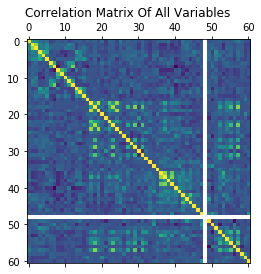


11 Highest total correlations:


,ALLOTHR,DRGSALE,P1VLNT,DISORDR,P1TOT,BURGLRY,DUI,STLNPRP,MJSALE,DRUGTOT,FRAUD
0,10.071163,9.422151,9.004683,8.887419,8.640175,8.563317,8.443245,7.858988,7.720977,7.679659,7.667487


In [201]:
corrdb = finaldb.corr().abs().sum()
corrdbl = pd.DataFrame(data=corrdb).nlargest(11,0).transpose()  # Largest correlations
corrdbs = pd.DataFrame(data=corrdb).nsmallest(10,0).transpose()   # Smallest correlations
# Creates a correlation matrix of all variables
plt.matshow(finaldb.corr())
plt.suptitle('Correlation Matrix Of All Variables\n')
plt.show()
cols = finaldb.columns.tolist()
print('\n11 Highest total correlations:')
corrdbl

In [202]:
l = corrdbl.columns.tolist() # variables to regress on
exp = l[1:] # Selects variable with highest total correlation to use as dependant variable
dep = l[0] # Uses next 10 most correlated variables to act as independant variables

# REGRESSION

Regression is of most correlated variable on next 10 most correlated variables

In [203]:
x = finaldb[exp]  # Select columns to use as independant vars
y = finaldb[dep]  # Set y variable

model = sm.OLS(y, x.astype(float)).fit()
predictions = model.predict(x) # make the predictions by the model

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                ALLOTHR   R-squared (uncentered):                   0.698
Model:                            OLS   Adj. R-squared (uncentered):              0.675
Method:                 Least Squares   F-statistic:                              30.33
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                    1.74e-29
Time:                        16:47:17   Log-Likelihood:                         -103.81
No. Observations:                 141   AIC:                                      227.6
Df Residuals:                     131   BIC:                                      257.1
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Regression of most correlated variable on all economic variables

In [204]:
x = finaldb[finaldb.columns.tolist()[3:18]]  # Selects all economic variables
y = finaldb[dep]  # Set y variable

model = sm.OLS(y, x.astype(float)).fit()
predictions = model.predict(x) # make the predictions by the model

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                ALLOTHR   R-squared (uncentered):                   0.081
Model:                            OLS   Adj. R-squared (uncentered):             -0.029
Method:                 Least Squares   F-statistic:                             0.7356
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                       0.745
Time:                        16:47:18   Log-Likelihood:                         -182.40
No. Observations:                 141   AIC:                                      394.8
Df Residuals:                     126   BIC:                                      439.0
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                                                               coef    std err          t      P>|t|      [0.025      0.

# Regression Summary

The first regression likely has the highest R-squared in our sample. Perhaps unsurprisingly we see that crime rates are more related to each other than with or between economic data. We also see that aggregate variables tend to be the strongest which makes sense again due to their interconnected nature.




In the second regression we can see the most correlated crime rate (total part 1 crimes; an aggregate of murder, rape, robbery, aggravated assault, burglary, larceny, auto theft, and arson) regressed on all of our economic variables. It is a substantially lower R-squared value and is no longer significant. 